# Predicting Housing Prices

## Introduction
Housing prices in certain parts of the US are on the rise. As a result, it is important for home buyers to be informed on the housing market by cross referencing prices with the various characteristics of a home. The question we will answer with our project is how the living room size, design and construction rating, and number of bathrooms, changes the price of homes sold in 2015. The dataset used to answer this question is called “House Sales in King County, USA” uploaded by user harlfoxem on Kaggle. The dataset includes 21  different variables listed below, for a total of 21614 observations with each observation being a different home in King County, USA.

##### price - Price of each home sold

##### bedrooms - Number of bedrooms

##### bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

##### sqft_living - Square footage of the apartments interior living space

##### sqft_lot - Square footage of the land space

##### floors - Number of floors

##### waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not

##### view - An index from 0 to 4 of how good the view of the property was
##### condition - An index from 1 to 5 on the condition of the apartment,

##### grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of 
##### construction and design.

##### sqft_above - The square footage of the interior housing space that is above ground level

##### sqft_basement - The square footage of the interior housing space that is below ground level

##### yr_built - The year the house was initially built

##### yr_renovated - The year of the house’s last renovation

## Methods and Results

In [1]:
#please run this cell for correct packages
library(tidyverse)
library(tidymodels)
library(dbplyr)
install.packages("gridExtra")
library(gridExtra)
install.packages("GGally")
library(GGally)
install.packages("kknn")
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

First we will begin by loading the data and plotting the variables to determine if there are any correlations with price

price  bedrooms bathrooms sqft_living sqft_lot floors waterfront view
1 490000 3        1.00       960         5750    1      0          0   
2 499160 4        2.50      2628        11466    2      0          0   
3 212000 2        1.00       790         7153    1      0          0   
4 339950 4        2.50      2150         4000    2      0          0   
5 926250 4        1.75      2390        17717    1      0          0   
  condition grade sqft_above sqft_basement yr_built yr_renovated
1 3         7      960       0             1951     0           
2 3         9     2628       0             2014     0           
3 4         6      790       0             1944     0           
4 3         7     2150       0             2010     0           
5 4         8     2390       0             1964     0

Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”


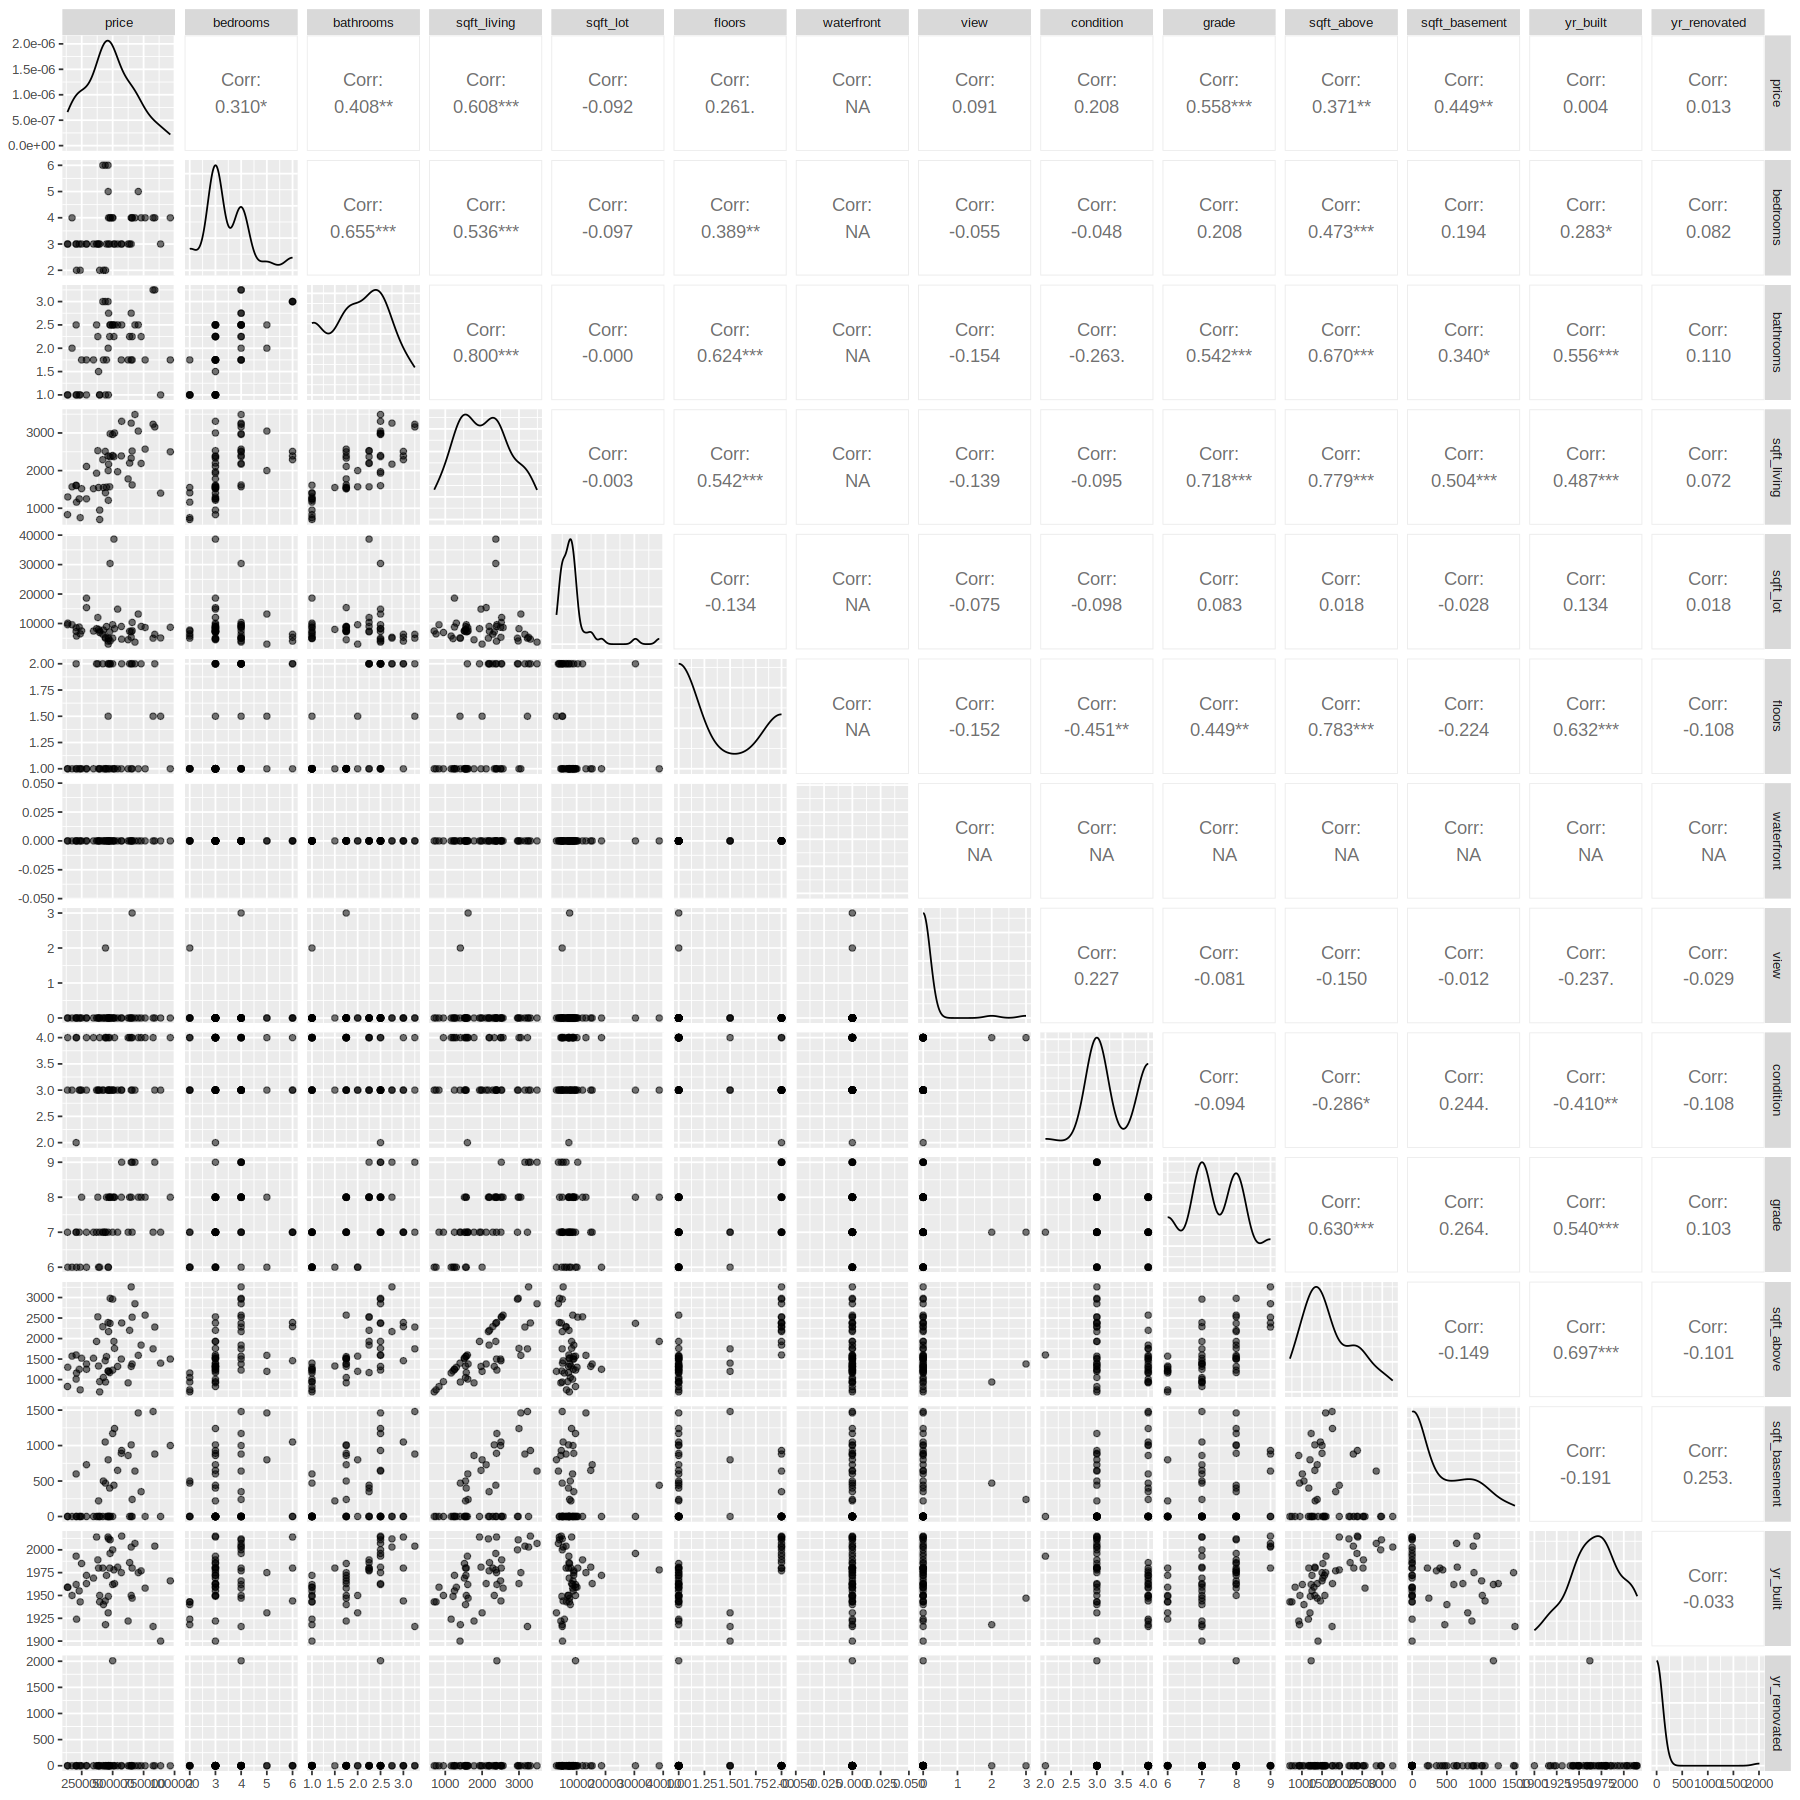

In [2]:
#Run to load data and observe correlations
options(repr.plot.width=15, repr.plot.height=15)
url <- "https://raw.githubusercontent.com/Moe-Jala/dsci-100-group-003-7/main/kc_house_data.csv"
housing_data <- read_csv(url, show_col_type = FALSE)|>
    filter(price < 3000000, sqft_lot<40000, date > as.POSIXct("2014-12-31")) |> #removing possible outliers
    select(price:yr_renovated)
sample_n(housing_data, 5)

housing_pairs <- housing_data|>
    sample_n(50) |>
    ggpairs(aes(alpha = 0.05))+
    theme(text = element_text(size=10))
housing_pairs


<br>
<br>

Based on our data correlation coefficients, we see that the variable most connected to price are living room size, number of bathrooms, and construction and design. The observed correlations intuitively align with logical expectations of factors that influence the price of a home. To further visualize these correltions, we will graph a close up look of a sample with an easily distinguishable trendline.

<br>

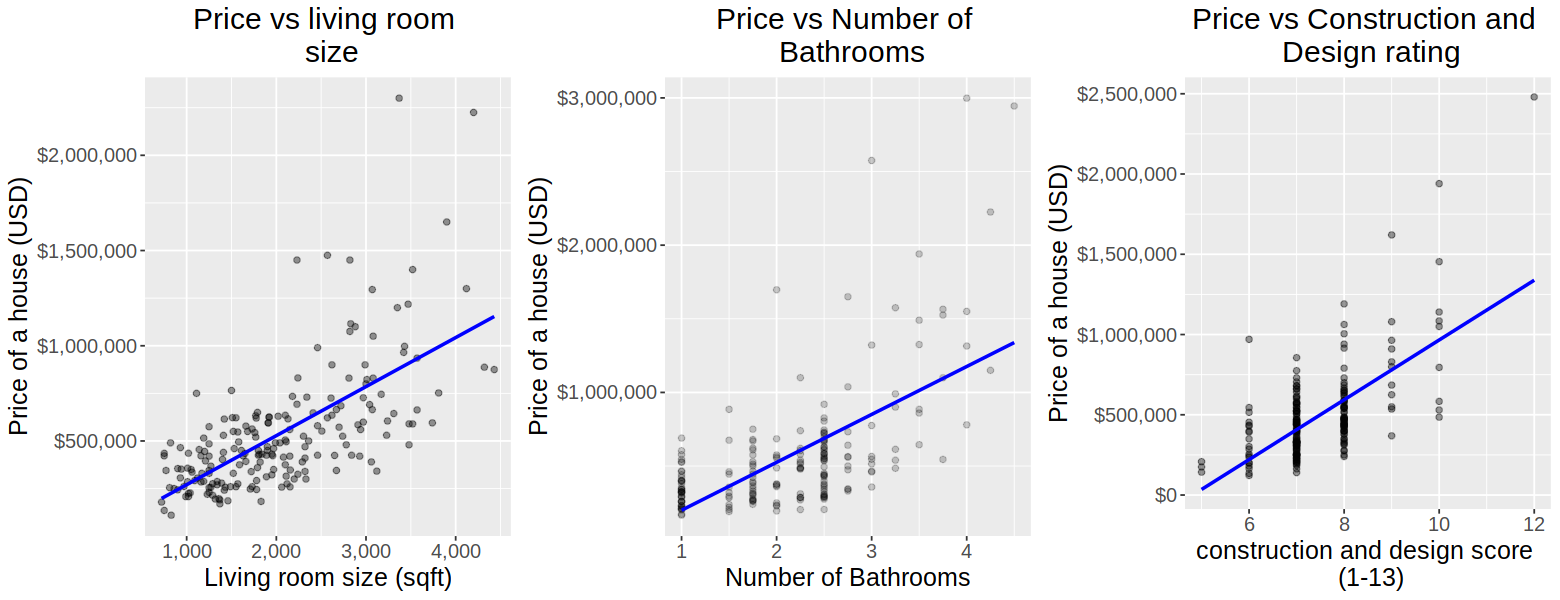

In [3]:
set.seed(69)
options(repr.plot.width=13, repr.plot.height=5)

price_versus_bathrooms_plot <- housing_data |>
    sample_n(200)|>
    ggplot(aes(x = bathrooms, y = price))+
        geom_point(alpha = 0.2)+
        labs(x = "Number of Bathrooms", y = "Price of a house (USD)")+
        theme(text = element_text(size=15)) +
        scale_x_continuous(labels = scales::comma)+
        scale_y_continuous(labels = dollar_format()) +
        ggtitle("Price vs Number of \n Bathrooms")+
        geom_smooth(method = "lm", se = FALSE, color = "blue", formula = y ~ x)+
        theme(plot.title = element_text(hjust = 0.5))

price_versus_size_plot <- housing_data |>
    sample_n(200)|>
    ggplot(aes(x = sqft_living, y = price))+
        geom_point(alpha = 0.4)+
        labs(x = "Living room size (sqft)", y = "Price of a house (USD)")+
        theme(text = element_text(size=15)) +
        scale_x_continuous(labels = scales::comma)+
        scale_y_continuous(labels = dollar_format()) +
        ggtitle("Price vs living room \n size")+
        geom_smooth(method = "lm", se = FALSE, color = "blue", formula = y ~ x)+
        theme(plot.title = element_text(hjust = 0.5))

price_versus_grade_plot <- housing_data |>
    sample_n(200)|>
    ggplot(aes(x = grade, y = price))+
        geom_point(alpha = 0.4)+
        labs(x = "construction and design score \n (1-13)", y = "Price of a house (USD)")+
        theme(text = element_text(size=15)) +
        scale_x_continuous(labels = scales::comma)+
        scale_y_continuous(labels = dollar_format()) +
        ggtitle("Price vs Construction and \n Design rating")+
        geom_smooth(method = "lm", se = FALSE, color = "blue", formula = y ~ x)+
        theme(plot.title = element_text(hjust = 0.5))

grid.arrange(price_versus_size_plot, price_versus_bathrooms_plot, price_versus_grade_plot, ncol = 3)

In [15]:
#make a couple of points about the graphs above. type of trend? good? bad? why would they make a good candidate for linear regression. why linear reg is better than knn

### Linear regression


<br>
To begin our analysis, we will construct a model employing linear regression to forecast house prices, taking into account the predetermined variables. To accomplish this, we initially designate the chosen variables. Subsequently, we partition the data into testing and training sets, which will be utilized later to compute the accuracy of the model.

<br>
<br>

In [11]:
#split data into training and testing
set.seed(69)
housing <- housing_data |>
    select(-sqft_basement)

housing_split <- initial_split(housing, prop = 0.75, strata = price)
housing_training <- training(housing_split)
housing_testing <- testing(housing_split)

<br>
Next, we construct the model by specifying linear regression as the engine and formulating a recipe based on the selected variables. Ultimately, we generate the model fit by utilizing the training data
<br>
<br>

In [5]:
#building the regression model
set.seed(69)
lm_spec <- linear_reg() |>
    set_engine("lm")|>
    set_mode("regression")

housing_recipe <- recipe(price ~ ., data = housing_training)

housing_fit <- workflow()|>
    add_recipe(housing_recipe)|>
    add_model(lm_spec)|>
    fit(data = housing_training)
housing_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)  sqft_living    bathrooms        grade  
  -595222.4        172.6     -40663.9     113984.0  


<br>
Looking at the coefficients we can examine the fomula our model uses to determine the price of a house: <br>
<strong> Price = -$595222 + (172 * living room size) + (113983 * grade) - (40663 * number of bathrooms)</strong> <br>
<br>
Interestingly we note that the number of bathrooms in our model is negatively correlated with price, but intuitively we would expect the price of a home to increase if it had more bathrooms and our graph earlier had a positive correlation too. Perheps linear regression isn't the best method to use with our variables as there may be some error due to collinearity amongst the variables.
<br>
<br>
Regradless, here we continue with testing the model with the testing set and graph 100 random predictions against the actual price.


.metric .estimator .estimate   
1 rmse    standard   2.305930e+05
2 rsq     standard   4.985891e-01
3 mae     standard   1.648698e+05

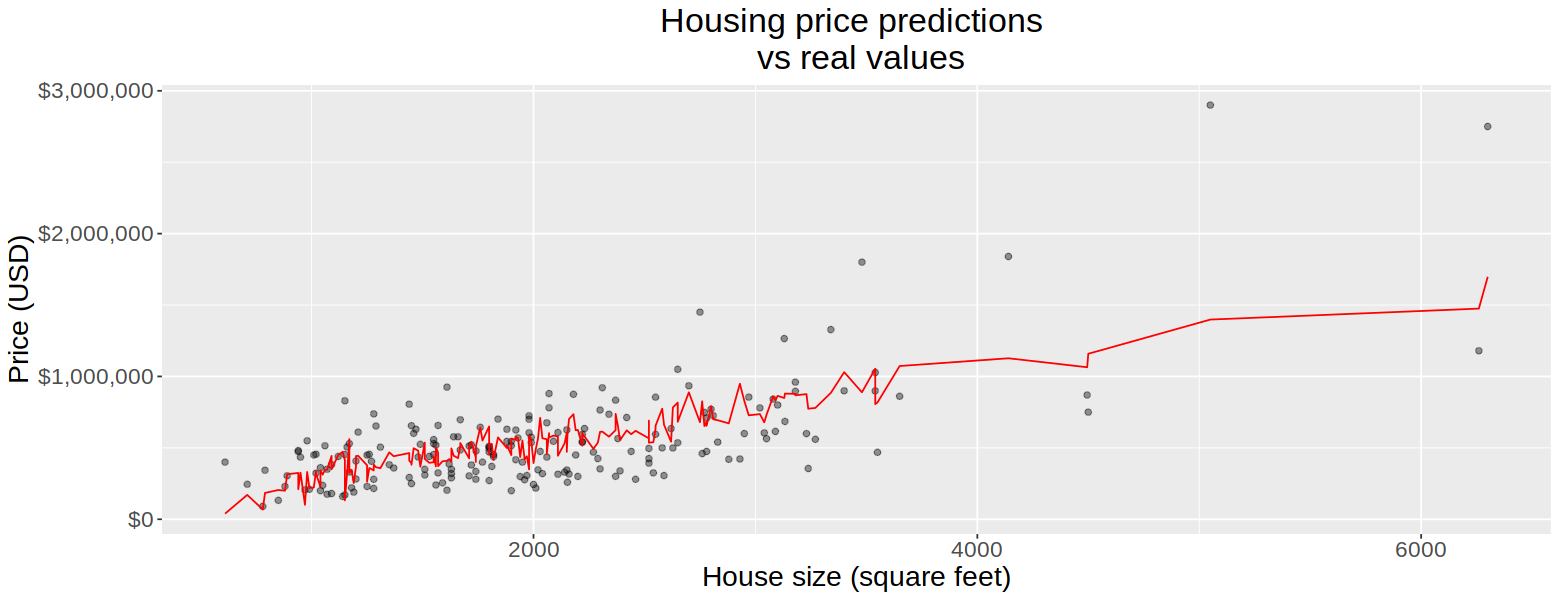

In [6]:
set.seed(69)

lm_results <- housing_fit|>
    predict(housing_testing)|>
    bind_cols(housing_testing)

lm_data <- lm_results |>
    metrics(truth = price, estimate = .pred)

sqft_prediction_grid <- tibble(
    sqft = c(
        housing |> select(sqft_living) |> min(),
        housing |> select(sqft_living) |> max()
    )
)

lm_sample <- sample_n(lm_results, 200)

lm_plot_final <- ggplot(lm_sample, aes(x = sqft_living, y = price)) +
  geom_point(alpha = 0.4) +
  geom_line(data = lm_sample, 
            mapping = aes(x = sqft_living, y = .pred), 
            color = "red") +
  xlab("House size (square feet)") +
  ylab("Price (USD)") +
  scale_y_continuous(labels = dollar_format()) +
  theme(text = element_text(size = 17))+
  ggtitle("Housing price predictions \n vs real values")+
  theme(plot.title = element_text(hjust = 0.5))

lm_plot_final
lm_data

In [7]:
#note about RMSPE 
#note about accuracy based on actual graph, specifically consider the $3Mil houses and what our model predicted. for sqft does our model fall apart

## Discussion
summarize what you found

discuss whether this is what you expected to find?
yes the model is pretty grabage - RMSPE of $230k - talk about the meaning of RMSPE
potential errors: 
house prices fluctuate over time - interest rates could be a huge factor! https://fred.stlouisfed.org/series/MSPUS since 2020 house prices are up 30%
other factors play a role in price, such as neighborhood, the damn kitchen appliences, other variables in the dataset  

discuss what impact could such findings have?

discuss what future questions could this lead to?


## References?

## K-nearest Neighbor Regression

In [12]:
#create tunning model to determine best K value for smallest RMSPE
housing_recipe <- recipe(price ~ ., data = housing_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

housing_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")


In [13]:
#Test model across vfolds and various K values
set.seed(69)
housing_vfold <- vfold_cv(housing_training, v = 5, strata = price)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 2))

housing_results <- workflow() |>
    add_recipe(housing_recipe) |>
    add_model(housing_tune_spec)|>
    tune_grid(resamples = housing_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")|>
    filter(mean == min(mean))|>
    pull(neighbors)
housing_results

[1] 9

In [14]:
#Remake model based on best K and evaluate on test set
set.seed(69)
housing_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = housing_results) |>
  set_engine("kknn") |>
  set_mode("regression")

housing_fit <- workflow() |>
    add_recipe(housing_recipe)|>
    add_model(housing_spec)|>
    fit(housing_training)

housing_summary <- housing_fit |>
  predict(housing_testing) |>
  bind_cols(housing_testing) |>
  metrics(truth = price, estimate = .pred)|>
  filter(.metric == 'rmse')
housing_summary

.metric .estimator .estimate
1 rmse    standard   194419.2